# Intro

Contributor(s): yr897021

Going to try feeding in pre processed data  and grouped/clustered data into different networks (perhaps U-Nets) or maybe some of my own previously trained models and see how it goes

#### This has been adapted from U-Net Starter Code shared <a href="https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277">here</a> authored by Kjetil Åmdal-Sævik <a href="https://www.kaggle.com/keegil">(keegil)<a>

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from skimage.morphology import label

In [3]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
TRAIN_PATH = './data/stage1_train/'
TEST_PATH = './data/stage1_test/'
patch_size = 128

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [4]:
# Get custom functions
from Cell_Helpers import *

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
%load_ext autoreload
%autoreload 2

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [8]:
# Get and resize train images and masks
X_train = []
Y_train = {}
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    X_train.append(img)
    mask = []
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        # For creating multiple masks for each image
        mask.append(imread(path + '/masks/' + mask_file))
        
    Y_train[n] = mask

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [10:56<00:00,  1.02it/s]

Done!


In [7]:
# save_images(X_train, Y_train, 'images.pickle', 'labels.pickle')
# Save the images to file
# save_images(X_train, Y_train)
X_train, Y_train = load_images()

### Separate all by histology/live cell

In [8]:
## Deal separately with BW images and with color images
X_train_bw, X_train_bw_maps = get_bw(X_train, Y_train, col = False)
X_train_col, X_train_col_maps = get_bw(X_train, Y_train, col=True)

### Separate live cell by fluoresence/bright field

In [9]:
find_bfield(X_train_bw, invert=True)

[20, 22, 53, 57, 94, 126, 148, 173, 184, 213, 215, 257, 278, 302, 311, 427]

### Correct for magnification

Quick pass on U-Net to detect size of nuclei and how to alter magnification 

In [26]:
X_train_bw_1patch = []

for img, maps in zip(X_train_bw, X_train_bw_maps):
    X_train_bw_1patch.append(get_patches(img, patch_size, one_only = True)[0])
    
# Combined 3D array of all patches from all images
train_set = np.array(X_train_bw_1patch)
train_feed = np.expand_dims(train_set, 3)

In [37]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-7.h5', custom_objects={'mean_iou': mean_iou})
preds = model.predict(train_feed, verbose=1)

# Threshold predictions
preds_t = (preds > 0.5).astype(np.uint8)

562/562 [==============================] - 12s 21ms/step


In [39]:
preds_t_clean = preds_t[:,:,:,0]

### Use the output from the crude prediction model to estimate magnification correction

In [76]:
# Measure the longest stretch of contiguous nuclei space in both x and y axes
def measure_contig_x(map_):
    count=0; count_max=0;
    for x in range(map_.shape[0]):
        for y in range(map_.shape[1]):
            if map_[x,y] == 1:
                count += 1
                if count>count_max:
                    count_max = count
            else:
                count = 0
    return count_max

def measure_contig_y(map_):
    count=0; count_max=0;
    for y in range(map_.shape[1]):
        for x in range(map_.shape[0]):
            if map_[x,y] == 1:
                count += 1
                if count>count_max:
                    count_max = count
            else:
                count = 0
    return count_max

def get_all_contig(maps):
    contig_x = [measure_contig_x(map_) for map_ in maps]
    contig_y = [measure_contig_y(map_) for map_ in maps]
    
    # Take the minimum contiguous dimesion to account for clumping to some extent
    contig = np.min(zip(contig_x,contig_y),1)
    
    return contig

In [ ]:
contig = get_all_contig(preds_t_clean)

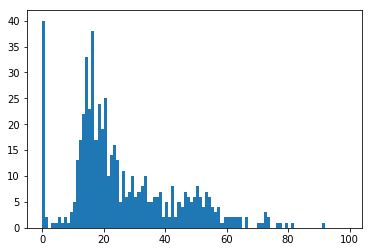

In [101]:
# Plot histogram of longest stretch of contiguous nuclei
_ = plt.hist(contig, bins = np.arange(0,100,1))

In [123]:
# Individualized resising for each map - needs to be functionalized
import cv2

map_orig = preds_t_clean[5]
contig_correct = 60/contig[5]

r = cv2.resize(map_orig, (map_orig.shape[0]*contig_correct, map_orig.shape[1]*contig_correct), interpolation = cv2.INTER_CUBIC)
#r = resize(map_orig, (map_orig.shape[0]*contig_correct, map_orig.shape[1]*contig_correct), mode='constant', preserve_range=True)

### Some more visualization

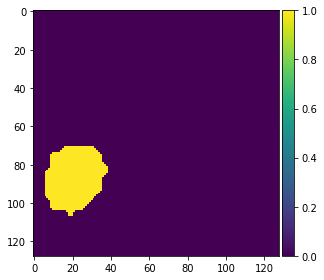

In [124]:
## Upscaling using cubic interpolation
imshow(r[-128:,:128])

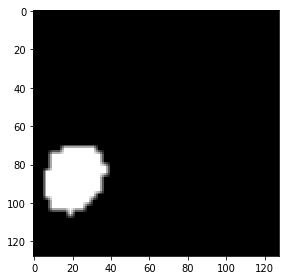

In [121]:
## Upsacling using linear interpolation
imshow(r[-128:,:128])

### Break into patches for easy processing

In [9]:
X_train_col_patches = []
X_train_col_maps_patches = []

for img, maps in zip(X_train_col, X_train_col_maps):
    X_train_bw_patches.append(get_patches(img, patch_size))
    #X_train_col_patches.append(get_patches(img, one_only = True)[0])
    
    maps = np.max(np.array(maps),0)
    X_train_bw_maps_patches.append(get_patches(maps, patch_size))
    #X_train_col_maps_patches.append(get_patches(maps, one_only = True)[0])

### Some visualizations

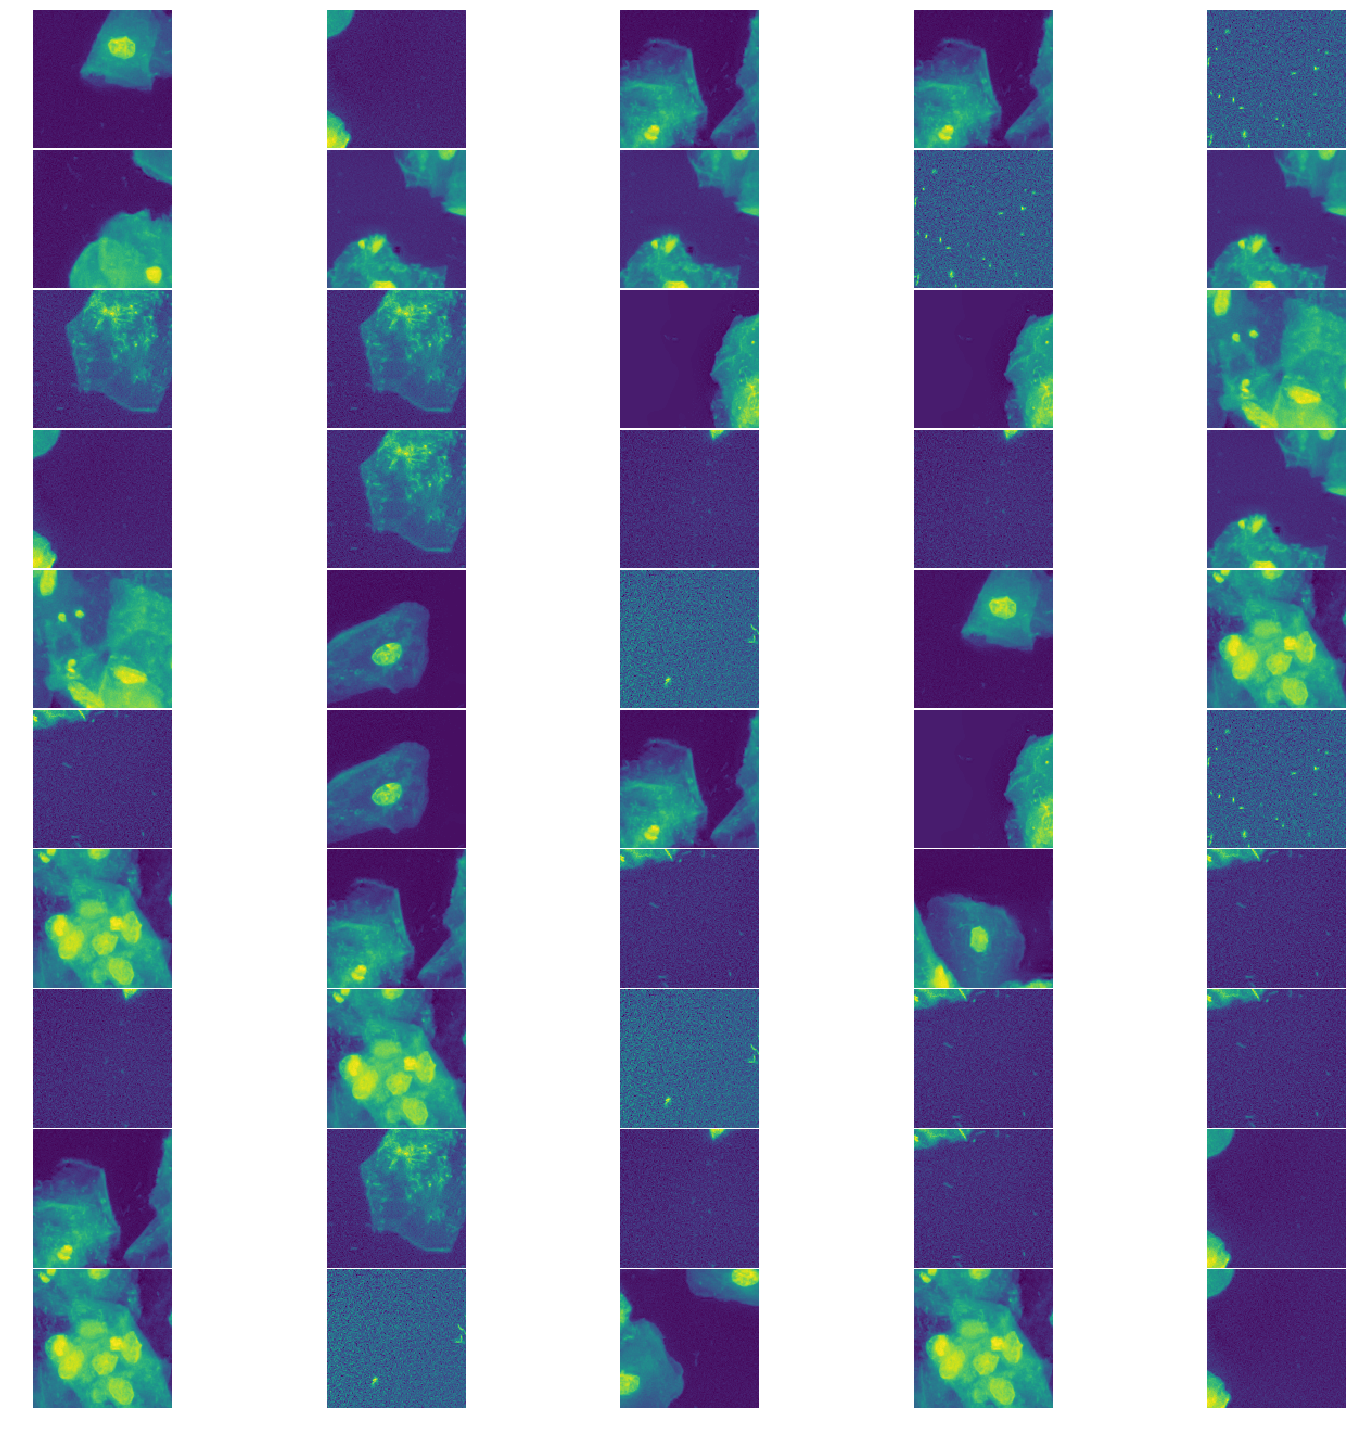

In [76]:
# Only looking at bright field
p = get_patches(X_train_bw[20])
_ = tile_collage(10,5,p)

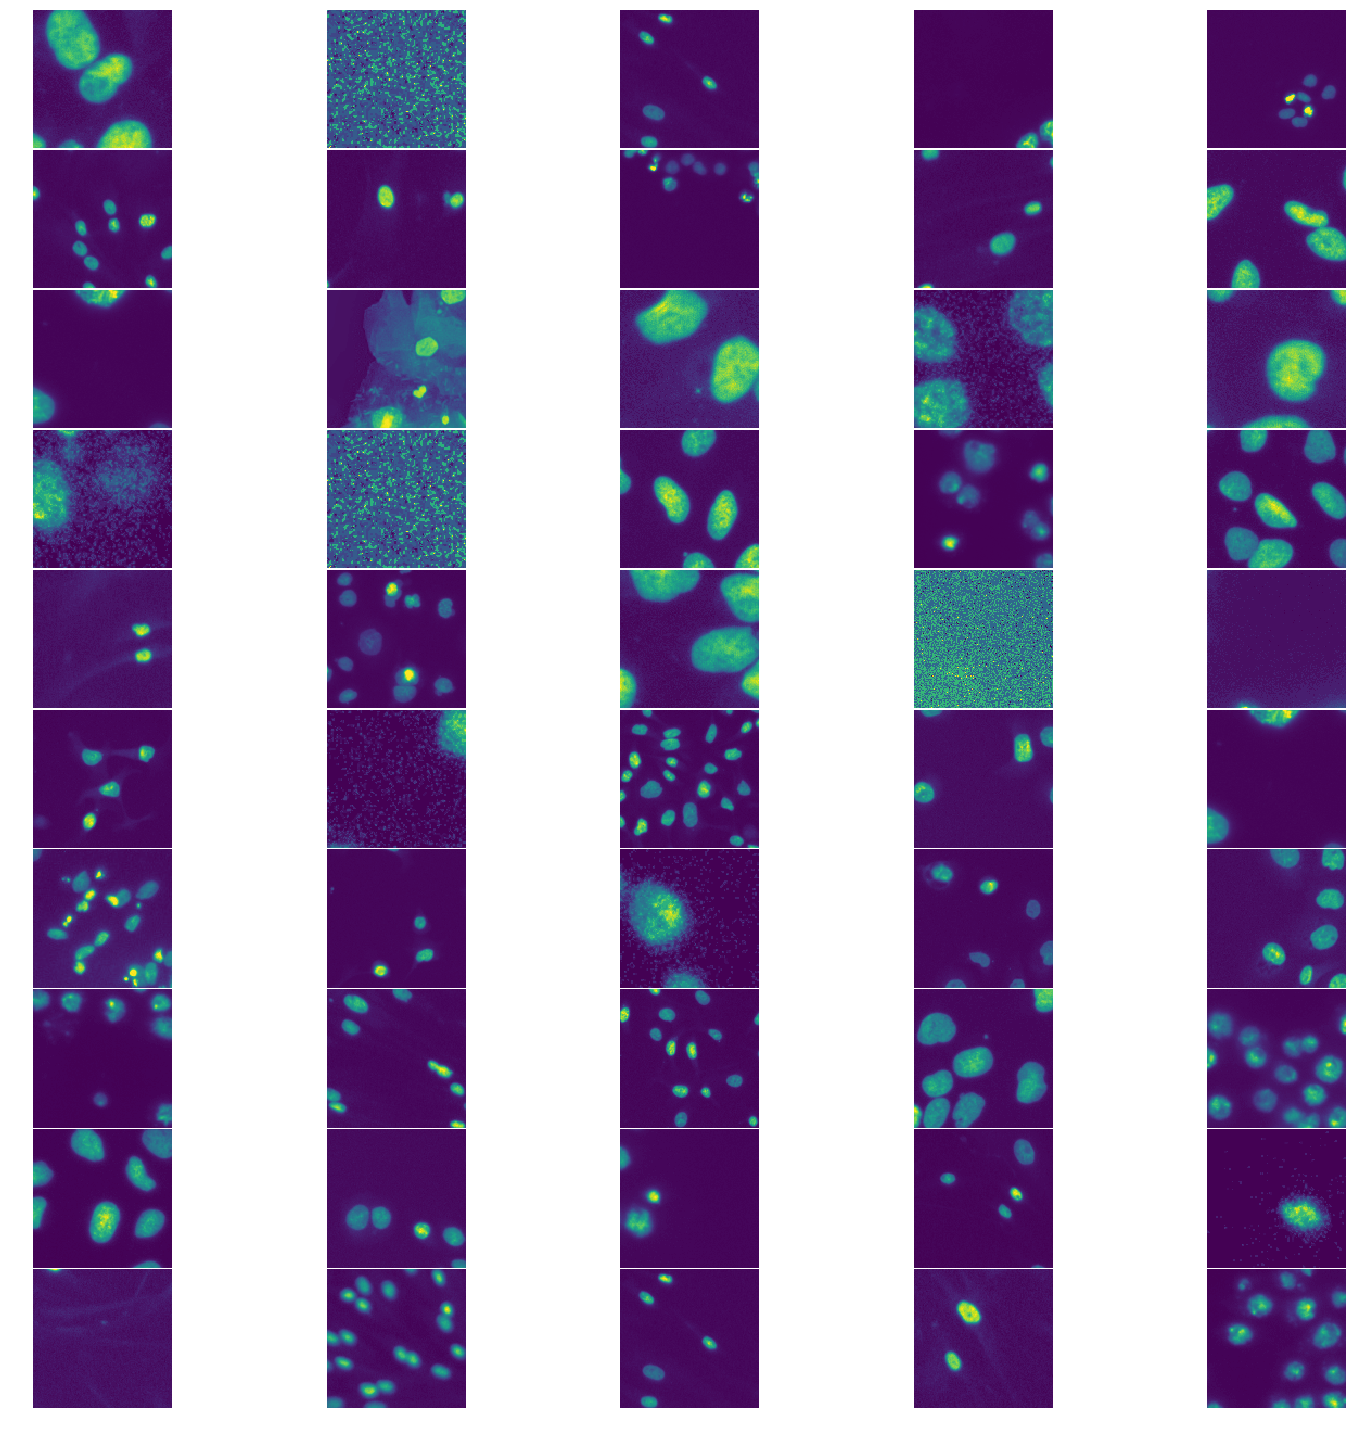

In [70]:
# Looking at fluoresence and bright field
from image_process import tile_collage
_ = tile_collage(10,5,X_train_bw_patches)

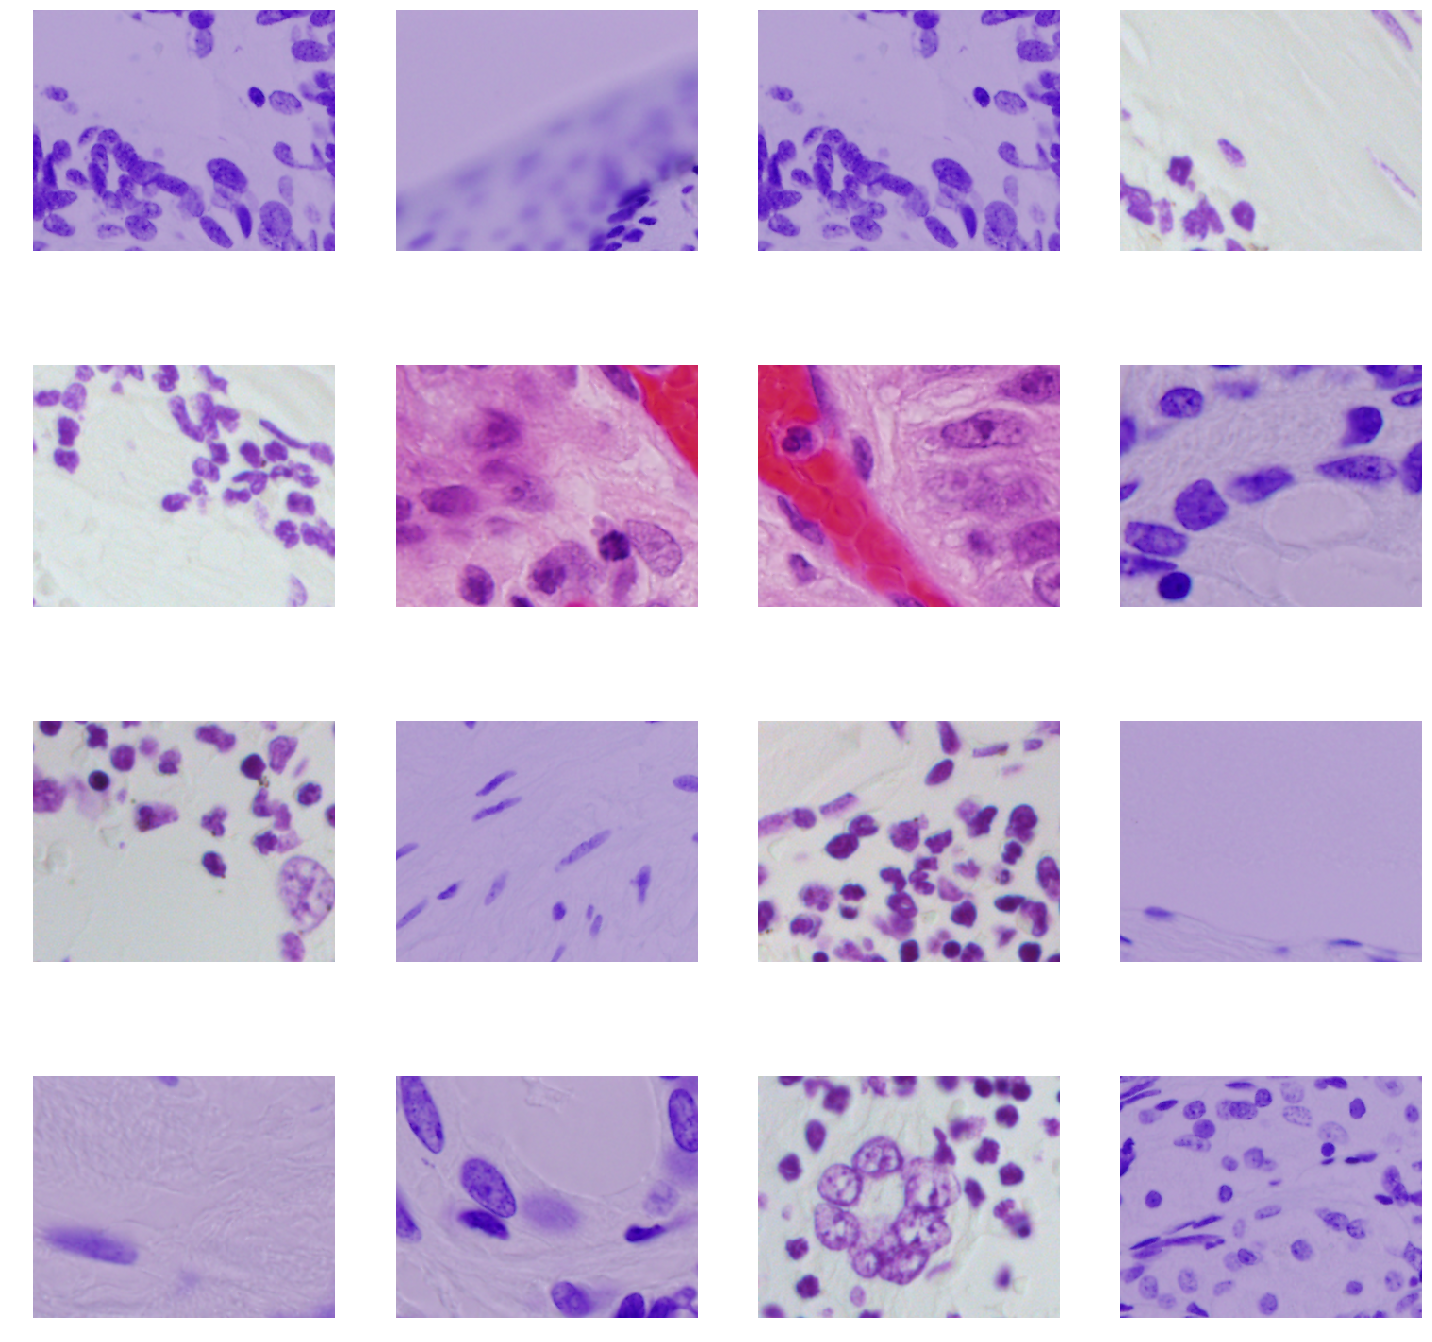

In [11]:
# Looking at histology
from image_process import tile_collage
_ = tile_collage(4,4,X_train_col)

### Define a training set

In [11]:
# Combined 3D array of all patches from all images
train_set = np.vstack(X_train_col_patches)
#train_set = np.expand_dims(train_set, 3)

In [13]:
train_set_labels = np.vstack(X_train_col_maps_patches)
#train_set_labels = np.expand_dims(train_set_labels,3)

### Build and train neural network

In [16]:
# Build U-Net model
inputs = Input((128, 128, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [11]:
# Define IoU metric - This needs to be fixed

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [18]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [24]:
train_set_labels = np.expand_dims(train_set_labels,3)

In [19]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-col.h5', verbose=1, save_best_only=True)
results = model.fit(train_set, train_set_labels.astype(np.bool), validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

ValueError: Error when checking target: expected conv2d_38 to have 4 dimensions, but got array with shape (648, 128, 128)

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

### Test data set

In [8]:
# Get and resize test images
X_test = []
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    X_test.append(img)
    
print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:02<00:00, 27.52it/s]

Done!


### First B/W (Live cell)

In [9]:
### Separate all by histology/live cell

## Deal separately with BW images and with color images
X_test_bw, X_test_bw_idxs = get_bw_idx(X_test, col = False)
X_test_col, X_test_col_idxs = get_bw_idx(X_test, col = True)

### Separate live cell by fluoresence/bright field

find_bfield(X_test_bw, invert=True)

### Break into patches for easy processing

X_test_bw_patches = []

for img in X_test_bw:
    X_test_bw_patches.append(get_patches(img, patch_size))

In [10]:
# Combined 3D array of all patches from all images
patches_feed = np.vstack(X_test_bw_patches)
patches_feed = np.expand_dims(patches_feed, 3)

In [11]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-7.h5', custom_objects={'mean_iou': mean_iou})
preds_test = model.predict(patches_feed, verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

560/560 [==============================] - 11s 20ms/step


In [12]:
# Post processing results

i = 0
pred_maps = {}

for img_no, img in enumerate(X_test_bw): 
    x_rng = get_x_rng(img, patch_size)
    y_rng = get_y_rng(img, patch_size)
    
    pred_map = np.zeros(img.shape) #Create a blank image
    
    for x in x_rng:
        for y in y_rng:
            pred_map[x:x+patch_size,y:y+patch_size] += preds_test_t[i,:,:,0]
            i += 1
    
    idx = X_test_bw_idxs[img_no]
    pred_maps[idx] = pred_map>0.5

### Then Color (Histology)

In [15]:
### Separate all by histology/live cell

## Deal separately with col images and with color images
X_test_col, X_test_col_idxs = get_bw_idx(X_test, col = True)

### Break into patches for easy processing
X_test_col_patches = []

for img in X_test_col:
    X_test_col_patches.append(get_patches(img, patch_size))

In [16]:
X_test_col_idxs

[5, 7, 12, 14, 19, 22, 24, 44, 49, 51, 56, 62]

In [19]:
# Combined 3D array of all patches from all images
patches_feed_col = np.vstack(X_test_col_patches)
#patches_feed_col = np.expand_dims(patches_feed, 3)

In [20]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-col_1.h5', custom_objects={'mean_iou': mean_iou})
preds_test = model.predict(patches_feed_col, verbose=1)

# Threshold predictions
preds_test_t_col = (preds_test > 0.5).astype(np.uint8)

252/252 [==============================] - 5s 21ms/step


In [22]:
# Post processing results

i = 0
#pred_maps = {}

for img_no, img in enumerate(X_test_col): 
    x_rng = get_x_rng(img, patch_size)
    y_rng = get_y_rng(img, patch_size)
    
    pred_map = np.zeros(img.shape[:2]) #Create a blank image
    
    for x in x_rng:
        for y in y_rng:
            pred_map[x:x+patch_size,y:y+patch_size] += preds_test_t_col[i,:,:,0]
            i += 1
    
    idx = X_test_col_idxs[img_no]
    pred_maps[idx] = pred_map>0.5

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

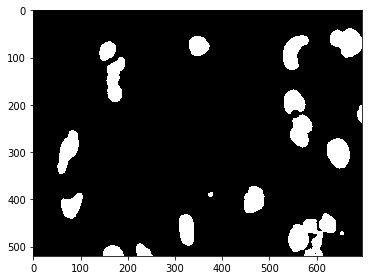

In [15]:
imshow(pred_maps[40])

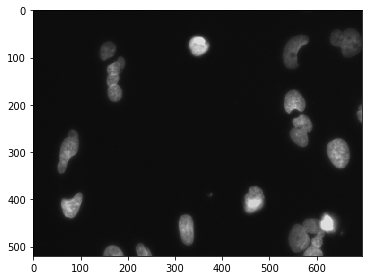

In [16]:
imshow(X_test_bw[40])

In [61]:
# pred_maps_submit = []
# for i, img in enumerate(X_test):
#    if i in X_test_bw_idxs:
#        pred_maps_submit.append(pred_maps[i])
#    else:
#        temp = np.zeros(img.shape[:2])
#        temp[0,0] = 1
#        pred_maps_submit.append(temp)

In [26]:
pred_maps_submit = pred_maps

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [27]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [30]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(pred_maps_submit[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [31]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)

In [65]:
sub

ImageId  \
0     0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
1     0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
2     0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
3     0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
4     0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
5     0114f484a16c152baa2d82fdd43740880a762c93f436c8...   
6     0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
7     0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
8     0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
9     0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
10    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
11    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
12    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
13    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
14    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
15    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
16    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
17    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
18    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
19    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
20    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
21    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
22    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
23    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
24    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
25    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
26    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
27    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
28    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
29    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...   
...                                                 ...   
1990  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1991  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1992  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1993  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1994  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1995  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1996  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1997  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1998  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
1999  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2000  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2001  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2002  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2003  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2004  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2005  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2006  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2007  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2008  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2009  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2010  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2011  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2012  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2013  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2014  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2015  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2016  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2017  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2018  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   
2019  fe9adb627a6f45747c5a8223b671774791ededf9364f65...   

                                          EncodedPixels  
0     45104 9 45358 12 45613 14 45869 14 46124 15 46...  
1     50024 5 50278 10 50533 12 50787 15 51042 16 51...  
2     10893 5 11147 8 11401 10 11656 12 11911 13 121...  
3     30878 2 31132 5 31388 6 31630 10 31643 7 31884...  
4     50842 4 51096 7 51350 10 51605 11 51860 12 521...  
5     38565 4 38819 7 39073 9 39327 12 39

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB